# **`Predição de Desempenho no Enem`**

Neste projeto, desenvolvemos um modelo preditivo para estimar a nota média dos candidatos do ENEM 2021 com base em suas características socioeconômicas. Utilizamos um conjunto de dados com 168.979 observações e 76 variáveis explicativas, aplicando técnicas de Machine Learning para obter a melhor performance preditiva.

O objetivo principal foi minimizar o erro do modelo, garantindo alta precisão para possíveis aplicações em uma página web. Para isso, realizamos tratamento de dados, seleção de features e treinamento de modelos.

-----------------------------------------------------------------------------------------------------------------------------------------------------

## 1. Import das bibliotecas

In [2]:
# ===============================
# 1. Manipulação de Dados
# ===============================
import pandas as pd
import numpy as np

# ===============================
# 2. Pré-processamento de Dados
# ===============================
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from feature_engine.encoding import MeanEncoder

# ===============================
# 3. Visualização de Dados
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ===============================
# 4. Estatísticas e Análise de Dados
# ===============================
from scipy.stats import skew, kurtosis

# ===============================
# 5. Divisão e Validação de Dados
# ===============================
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV

# ===============================
# 6. Modelos de Machine Learning
# ===============================
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    ExtraTreesRegressor, 
    HistGradientBoostingRegressor
)
import xgboost as xgb

# ===============================
# 7. Seleção de Features
# ===============================
from boruta import BorutaPy

# ===============================
# 8. Otimização de Hiperparâmetros
# ===============================
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# ===============================
# 9. Métricas de Avaliação
# ===============================
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ===============================
# 10. Salvamento e Carregamento de Modelos
# ===============================
import joblib
import pickle
from dotenv import load_dotenv
import os

# ===============================
# 11. Configurações Gerais
# ===============================
import warnings
warnings.filterwarnings("ignore")

## 2. Pré-Processamento de Dados

### 2.1 Leitura da base de dados

In [3]:
# Carrega as variáveis do arquivo .env
load_dotenv()

# Obtém o caminho do arquivo CSV da variável de ambiente
caminho_arquivo = os.getenv("CAMINHO_ENEM")

# Verifica se a variável foi carregada corretamente
if caminho_arquivo is None:
    raise ValueError("Caminho do arquivo não encontrado. Verifique o arquivo .env")

# Lê o arquivo CSV
dataset_enem = pd.read_csv(caminho_arquivo)

dataset_enem.head()

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_MEDIA
0,210054403757,2021,14,M,2,3,1,1,15,1,...,A,A,B,A,A,B,A,A,A,NaN
1,210053662224,2021,5,F,1,3,1,1,4,1,...,A,A,B,A,A,C,A,B,B,546.56
2,210053154359,2021,14,F,0,3,1,1,12,1,...,A,A,B,A,A,B,A,A,A,431.38
3,210054036560,2021,3,F,1,4,1,2,0,2,...,A,A,B,A,A,C,A,A,B,565.80
4,210051462654,2021,2,F,1,4,1,2,0,3,...,A,A,E,A,A,E,A,B,B,576.12


### 2.2 Seleção das Variáveis Iniciais
O dataset inicial possui 76 variáveis e o desfecho (motivo da predição) que é a variável 'NU_MEDIA' **nota média de desempenho do aluno no Enem de 2021**.

A seleção de variáveis foi realizada com o objetivo de diminuir a quantidade de features para a modelagem, analisando como cada variável pode impactar o desfecho e **retirando as variáveis** que estão **intrinsecamente relacionadas com a nota média de desempenho**, que são as notas individuais em cada área de conhecimento da prova.

In [4]:
variaveis_selecionadas = [
    "TP_FAIXA_ETARIA", "TP_ESTADO_CIVIL", "TP_NACIONALIDADE", "TP_ST_CONCLUSAO",
    "TP_ANO_CONCLUIU", "TP_ESCOLA", "TP_ENSINO", "TP_DEPENDENCIA_ADM_ESC",
    "TP_LOCALIZACAO_ESC", "TP_PRESENCA_CN", "TP_PRESENCA_CH", "TP_PRESENCA_LC",
    "TP_PRESENCA_MT", "TP_LINGUA", "Q001", "Q002", "Q003", "Q004", "Q005",
    "Q006", "Q007", "Q008", "Q009", "Q010", "Q011", "Q012", "Q013", "Q014",
    "Q015", "Q016", "Q017", "Q018", "Q019", "Q020", "Q021", "Q022", "Q023",
    "Q024", "Q025","NU_MEDIA"
]

df_enem_features = dataset_enem[variaveis_selecionadas]

df_enem_features.head()

,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_PRESENCA_CN,...,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_MEDIA
0,14,2,1,1,15,1,NaN,NaN,NaN,0,...,A,A,B,A,A,B,A,A,A,NaN
1,5,1,1,1,4,1,NaN,NaN,NaN,1,...,A,A,B,A,A,C,A,B,B,546.56
2,14,0,1,1,12,1,NaN,NaN,NaN,1,...,A,A,B,A,A,B,A,A,A,431.38
3,3,1,1,2,0,2,1.0,2.0,1.0,1,...,A,A,B,A,A,C,A,A,B,565.80
4,2,1,1,2,0,3,1.0,4.0,1.0,1,...,A,A,E,A,A,E,A,B,B,576.12


### 2.3 **Dropando** as linhas do dataset quando o valor de **NU_MEDIA é nulo**

In [5]:
df_enem_features_pronto = df_enem_features.dropna(subset=["NU_MEDIA"])

In [6]:
df_enem_features_pronto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110234 entries, 1 to 168977
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   TP_FAIXA_ETARIA         110234 non-null  int64  
 1   TP_ESTADO_CIVIL         110234 non-null  int64  
 2   TP_NACIONALIDADE        110234 non-null  int64  
 3   TP_ST_CONCLUSAO         110234 non-null  int64  
 4   TP_ANO_CONCLUIU         110234 non-null  int64  
 5   TP_ESCOLA               110234 non-null  int64  
 6   TP_ENSINO               40416 non-null   float64
 7   TP_DEPENDENCIA_ADM_ESC  29619 non-null   float64
 8   TP_LOCALIZACAO_ESC      29619 non-null   float64
 9   TP_PRESENCA_CN          110234 non-null  int64  
 10  TP_PRESENCA_CH          110234 non-null  int64  
 11  TP_PRESENCA_LC          110234 non-null  int64  
 12  TP_PRESENCA_MT          110234 non-null  int64  
 13  TP_LINGUA               110234 non-null  int64  
 14  Q001                    1

### 2.4 **Dropando** as variáveis **TP_ENSINO, TP_DEPENDENCIA_ADM_ESC e TP_LOCALIZACAO_ESC** por possuírem um percentual muito alto de valores nulos.

In [7]:
df_enem_features_pronto = df_enem_features_pronto.drop(columns=["TP_ENSINO", "TP_DEPENDENCIA_ADM_ESC", "TP_LOCALIZACAO_ESC"])

df_enem_features_pronto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110234 entries, 1 to 168977
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   TP_FAIXA_ETARIA   110234 non-null  int64  
 1   TP_ESTADO_CIVIL   110234 non-null  int64  
 2   TP_NACIONALIDADE  110234 non-null  int64  
 3   TP_ST_CONCLUSAO   110234 non-null  int64  
 4   TP_ANO_CONCLUIU   110234 non-null  int64  
 5   TP_ESCOLA         110234 non-null  int64  
 6   TP_PRESENCA_CN    110234 non-null  int64  
 7   TP_PRESENCA_CH    110234 non-null  int64  
 8   TP_PRESENCA_LC    110234 non-null  int64  
 9   TP_PRESENCA_MT    110234 non-null  int64  
 10  TP_LINGUA         110234 non-null  int64  
 11  Q001              110234 non-null  object 
 12  Q002              110234 non-null  object 
 13  Q003              110234 non-null  object 
 14  Q004              110234 non-null  object 
 15  Q005              110234 non-null  float64
 16  Q006              110234 

### 2.5 Engenharia de Features

Transformação de variáveis texto para numéricas, utilizando o **label encoder** onde a ideia é substituir categorias como 'Sim' e 'Não' por 1 e 0.

In [8]:
# Criando o objeto LabelEncoder
label_encoder = LabelEncoder()

# Lista de colunas a serem transformadas
colunas_label = ["Q018", "Q020", "Q021", "Q023", "Q025"]

# Aplicando o LabelEncoder em cada coluna
for col in colunas_label:
    df_enem_features_pronto[col] = label_encoder.fit_transform(df_enem_features_pronto[col])

# Verificando se as transformações foram aplicadas
df_enem_features_pronto[colunas_label].head()

,Q018,Q020,Q021,Q023,Q025
1,0,0,0,0,1
2,0,0,0,0,0
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1


Transformação de variáveis com categorias de A té E para numéricas

Como as variáveis possuem uma ordem de grandeza dentro das próprias categorias, é trivial manter essa ordem de grandeza substituindo pelo número respectivo.

In [9]:
# Dicionário de mapeamento
mapeamento = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

# Lista de colunas para aplicar a substituição
colunas = ["Q008", "Q009", "Q010", "Q011", "Q012", "Q013", 
           "Q014", "Q015", "Q016", "Q017", "Q019", "Q022", "Q024"]

# Aplicando o mapeamento nas colunas selecionadas
df_enem_features_pronto[colunas] = df_enem_features_pronto[colunas].replace(mapeamento)

# Verificando as primeiras linhas para conferir a substituição
print(df_enem_features_pronto[colunas].head())

   Q008  Q009  Q010  Q011  Q012  Q013  Q014  Q015  Q016  Q017  Q019  Q022  \
1     1     2     0     1     1     0     0     1     0     0     1     2   
2     1     1     1     0     1     0     1     0     0     0     1     1   
3     1     2     0     0     1     0     1     1     0     0     1     2   
4     4     3     3     1     1     1     1     1     1     0     4     4   
5     1     2     0     0     1     1     0     1     0     0     1     4   

   Q024  
1     1  
2     0  
3     0  
4     1  
5     0  


## 3. Data Splitting

Como vamos iniciar o tratamento de variáveis utilizando transformações e scalers, devemos separar o nosso conjunto de dados em treino e teste para evitar vazamento de dados. Todos os scalers aplicados no treinamento, devem ser aplicados no teste antes da predição.

Como o desfecho é uma variável numérica, não podemos fazer a divisão treino e teste de maneira tradicional, estratificando a variável. **Então vamos analisar se 'NU_MEDIA' possui uma distribuição parecida com a normal. Caso isso ocorra, podemos fazer a divisão apenas de maneira aleatória**.

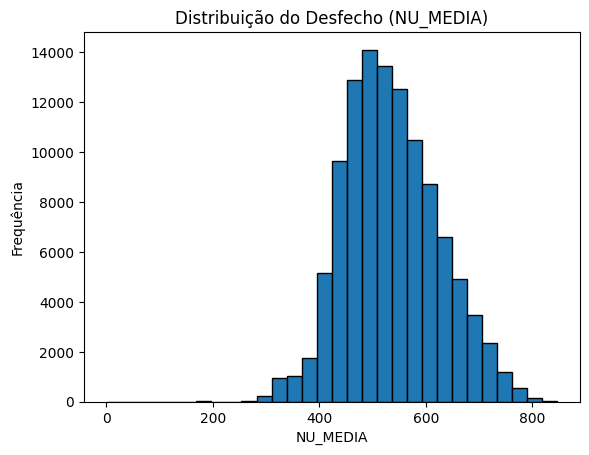

In [10]:
plt.hist(df_enem_features_pronto["NU_MEDIA"], bins=30, edgecolor="black")
plt.xlabel("NU_MEDIA")
plt.ylabel("Frequência")
plt.title("Distribuição do Desfecho (NU_MEDIA)")
plt.show()

In [11]:
print("Assimetria da variável NU_MEDIA:", skew(df_enem_features_pronto["NU_MEDIA"]))
print("Curtose da variável NU_MEDIA:", kurtosis(df_enem_features_pronto["NU_MEDIA"]))

Assimetria da variável NU_MEDIA: 0.2679862898665952
Curtose da variável NU_MEDIA: -0.09708108320416997


In [12]:
# Calcular o desvio padrão
std_dev = df_enem_features_pronto['NU_MEDIA'].std()
print("O desvio padrão da variável NU_MEDIA é:", std_dev)

O desvio padrão da variável NU_MEDIA é: 88.80424985809748


Valores de referêcia para a distribuição normal
- Assimetria entre: -0.5 e 0.5
- Curtose entre: -1 e 1

**Logo o nosso desfecho possui uma distribuição parecida com a Normal e a divisão pode ser feita de maneira aleatória.**

Resetando o index após as diversas transformações que foram realizadas, apenas como forma de garantia para divisão aleatória.

In [13]:
df_enem_features_pronto = df_enem_features_pronto.reset_index(drop=True)

### 3.1 Divisão Treino, Validação e Teste

In [14]:
# Defina as variáveis independentes (X) e a variável dependente (y)
X = df_enem_features_pronto.drop(columns=["NU_MEDIA"])  # Excluindo a variável target
y = df_enem_features_pronto["NU_MEDIA"]  # Variável target

# Primeira divisão: treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Segunda divisão: teste e validação (50% teste, 50% validação)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### 3.2 Aplicação do **OneHot Encoder**

In [15]:
# Lista das colunas categóricas que serão transformadas
colunas_categoricas = ["Q001", "Q002", "Q003", "Q004", "Q007"]

# Inicializando o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' evita multicolinearidade

# Aplicando o encoder e transformando em DataFrame
X_train_encoded = encoder.fit_transform(X_train[colunas_categoricas])

# Criando um DataFrame com os novos nomes das colunas
nomes_colunas = encoder.get_feature_names_out(colunas_categoricas)
X_train_encoded = pd.DataFrame(X_train_encoded, columns=nomes_colunas, index=X_train.index)

# Concatenando com o dataset original (removendo as colunas originais e adicionando as transformadas)
X_train = X_train.drop(columns=colunas_categoricas)  # Remover as colunas originais
X_train = pd.concat([X_train, X_train_encoded], axis=1)  # Concatenando as novas colunas

### 3.3 Salvar OneHot Encoder para aplicação posterior

In [16]:
# Caminho para salvar o encoder
caminho_encoder = "onehot_encoder_treino.pkl"

# Salvando o encoder treinado
joblib.dump(encoder, caminho_encoder)

print(f"OneHotEncoder salvo em {caminho_encoder}")

OneHotEncoder salvo em onehot_encoder_treino.pkl


### 3.4 Target Enconding

In [17]:
X_train["Q006"] = X_train["Q006"].astype("category")
print("Categorias em X_train['Q006']: ", X_train["Q006"].cat.categories)

Categorias em X_train['Q006']:  Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q'],
      dtype='object')


In [18]:
# Inicializando o MeanEncoder para a variável "Q006"
encoder_target = MeanEncoder(variables=["Q006"])

# Aplicando o Target Encoding no treino
X_train["Q006"] = encoder_target.fit_transform(X_train[["Q006"]], y_train)

# Verificando os resultados
print(X_train["Q006"].head())

39147     491.731987
49964     576.862804
81950     491.731987
35836     491.731987
107048    475.792182
Name: Q006, dtype: float64


### 3.5 Salvar Target Enconding para aplicação posterior

In [19]:
# Salvando o encoder treinado
joblib.dump(encoder_target, "target_encoder_treino.pkl")

print("Target Encoder salvo como 'target_encoder_treino.pkl'")

Target Encoder salvo como 'target_encoder_treino.pkl'


### 3.6 Aplicação do Standard Scaler

Após transformar todas as variáveis em numéricas, vamos escalar essas variáveis para que possuam média 0 e desvio padrão igual a 1.

In [20]:
# Inicializando o StandardScaler
scaler = StandardScaler()

# Aplicando o fit_transform para ajustar e transformar os dados de X_train
X_train_scaled = scaler.fit_transform(X_train)

# Se você quiser transformar os dados novamente em um DataFrame com os mesmos nomes de colunas:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Verificando os dados escalados
X_train_scaled.head()

,TP_FAIXA_ETARIA,TP_ESTADO_CIVIL,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,...,Q003_E,Q003_F,Q004_B,Q004_C,Q004_D,Q004_E,Q004_F,Q007_B,Q007_C,Q007_D
39147,0.409438,-0.095639,4.757511,-0.958775,-0.531180,-0.710021,0.0,0.0,0.0,0.0,...,-0.311098,-0.335840,-0.794122,-0.254764,-0.628229,-0.262577,-0.289843,-0.233975,-0.111707,-0.186251
49964,-0.711394,-0.095639,-0.129648,1.728986,-0.531180,-0.710021,0.0,0.0,0.0,0.0,...,-0.311098,-0.335840,-0.794122,-0.254764,1.591776,-0.262577,-0.289843,-0.233975,-0.111707,-0.186251
81950,-0.991602,-0.095639,-0.129648,1.728986,-0.531180,-0.710021,0.0,0.0,0.0,0.0,...,-0.311098,-0.335840,-0.794122,-0.254764,-0.628229,-0.262577,3.450147,-0.233975,-0.111707,-0.186251
35836,1.530269,-0.095639,4.757511,-0.958775,1.036497,-0.710021,0.0,0.0,0.0,0.0,...,-0.311098,-0.335840,1.259253,-0.254764,-0.628229,-0.262577,-0.289843,-0.233975,-0.111707,-0.186251
107048,-0.150978,2.679774,-0.129648,-0.958775,-0.269900,-0.710021,0.0,0.0,0.0,0.0,...,-0.311098,2.977605,-0.794122,-0.254764,-0.628229,-0.262577,-0.289843,-0.233975,-0.111707,-0.186251


### 3.7 Salvar Scaler para aplicação posterior

In [21]:
# Salvando o encoder treinado
joblib.dump(scaler, "standard_scaler_treinamento.pkl")

print("Standard Scaler salvo como 'standard_scaler_treinamento.pkl'")

Standard Scaler salvo como 'standard_scaler_treinamento.pkl'


## 4. Padronização dos Conjuntos de Dados de Validação e Teste

Carregando OneHot Encoder, Target Enconding e Standard Scaler

In [22]:
# Carregando os objetos salvos
onehot = joblib.load("onehot_encoder_treino.pkl")
target_encoder = joblib.load("target_encoder_treino.pkl")
standard_scaler = joblib.load("standard_scaler_treinamento.pkl")

### 4.1 Aplicação OneHot Encoder

In [23]:
colunas_categoricas = ["Q001", "Q002", "Q003", "Q004", "Q007"]

# Aplicação no Conjunto de Validação
X_validation_encoded = onehot.transform(X_validation[colunas_categoricas])
X_validation_encoded = pd.DataFrame(X_validation_encoded, columns=onehot.get_feature_names_out(colunas_categoricas), index=X_validation.index)
# Remover as colunas originais e adicionar as transformadas
X_validation = X_validation.drop(columns=colunas_categoricas)
X_validation = pd.concat([X_validation, X_validation_encoded], axis=1)

# Aplicação no Conjunto de Teste
X_test_encoded = onehot.transform(X_test[colunas_categoricas])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=onehot.get_feature_names_out(colunas_categoricas), index=X_test.index)
# Remover as colunas originais e adicionar as transformadas
X_test = X_test.drop(columns=colunas_categoricas)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

### 4.2 Aplicação do Target Enconding

In [24]:
# Aplicação no Conjunto de Validação
X_validation["Q006"] = X_validation["Q006"].map(target_encoder.encoder_dict_["Q006"])
X_validation["Q006"] = X_validation["Q006"].astype(float)

# Aplicação no Conjunto de Teste
X_test["Q006"] = X_test["Q006"].map(target_encoder.encoder_dict_["Q006"])
X_test["Q006"] = X_test["Q006"].astype(float)

### 4.3 Aplicação do Standard Scaler

In [25]:
# Aplicando a transformação no conjunto de validação
X_validation_scaled = scaler.transform(X_validation)
# Convertendo de volta para DataFrame, se necessário
X_validation = pd.DataFrame(X_validation_scaled, columns=X_validation.columns, index=X_validation.index)

# Aplicando a transformação no conjunto de teste
X_test_scaled = scaler.transform(X_test)
# Convertendo de volta para DataFrame, se necessário
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## 5. Treinamento de modelos de árvores de decisão para regressão
- Decision Tree Regressor
- Random Forest Regressor
- XGBoost Regressor
- Gradient Boosting Regressor
- ExtraTree Regressor
- HistGradientBoosting Regressor

In [26]:
# Definindo os modelos de árvore para regressão
modelos_arvore = {
    "DecisionTree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=100, max_depth=5, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Treinando e salvando os modelos
for nome, modelo in modelos_arvore.items():
    print(f"Treinando {nome}...")
    modelo.fit(X_train_scaled, y_train)
    print(f"{nome} treinado com sucesso!")

    # Salvando o modelo treinado
    joblib.dump(modelo, f"{nome}.pkl")
    print(f"{nome} salvo como {nome}.pkl\n")

Treinando DecisionTree...
DecisionTree treinado com sucesso!
DecisionTree salvo como DecisionTree.pkl

Treinando RandomForest...
RandomForest treinado com sucesso!
RandomForest salvo como RandomForest.pkl

Treinando XGBoost...
XGBoost treinado com sucesso!
XGBoost salvo como XGBoost.pkl

Treinando GradientBoosting...
GradientBoosting treinado com sucesso!
GradientBoosting salvo como GradientBoosting.pkl

Treinando ExtraTrees...
ExtraTrees treinado com sucesso!
ExtraTrees salvo como ExtraTrees.pkl

Treinando HistGradientBoosting...
HistGradientBoosting treinado com sucesso!
HistGradientBoosting salvo como HistGradientBoosting.pkl



### 5.1 Predição no conjunto de Teste

Predição dos modelos baseline no conjunto de teste para verificar quais modelos tiveram um aprendizado melhor.

In [27]:
# Criando um dicionário para armazenar os resultados
resultados = {}

# Loop para avaliar cada modelo
for nome in ["DecisionTree", "RandomForest", "XGBoost", "GradientBoosting", "ExtraTrees", "HistGradientBoosting"]:
    # Carregar o modelo salvo
    modelo = joblib.load(f"{nome}.pkl")

    # Fazer previsões no conjunto de teste
    y_pred = modelo.predict(X_test_scaled)

    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Salvar os resultados
    resultados[nome] = {"R²": r2, "RMSE": rmse, "MAE": mae}

# Exibir os resultados
df_resultados = pd.DataFrame(resultados).T
print(df_resultados.sort_values(by="R²", ascending=False))

                            R²       RMSE        MAE
GradientBoosting      0.353464  70.898791  55.988320
XGBoost               0.353260  70.909962  56.005655
HistGradientBoosting  0.353171  70.914855  55.958966
RandomForest          0.311974  73.138298  57.895482
ExtraTrees            0.301881  73.672811  58.285584
DecisionTree          0.300239  73.759429  58.395690


Os modelos de Gradient Boosting tiveram uma performance melhor, iremos otimizar os parâmetros do **Gradient Boosting e do XGBoost** utilizando o conjunto de validação.

## 6. Otimização de Hiperparâmetros

In [28]:
# Carregar o modelo Gradient Boosting
gradientboosting_baseline = joblib.load("GradientBoosting.pkl")

# Carregar o modelo XGBoost
xgboost_baseline = joblib.load("XGBoost.pkl")

# Verificar se os modelos foram carregados corretamente
print("Modelos carregados com sucesso!")
print("GradientBoosting:", type(gradientboosting_baseline))
print("XGBoost:", type(xgboost_baseline))

Modelos carregados com sucesso!
GradientBoosting: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
XGBoost: <class 'xgboost.sklearn.XGBRegressor'>


### 6.1 Randomized Search

In [29]:
# Definindo hiperparâmetros para busca
param_grid_gb = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0]
}

param_grid_xgb = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "subsample": [0.7, 0.8, 1.0]
}


# Randomized Search para GradientBoosting
random_search_gb = RandomizedSearchCV(
    estimator=gradientboosting_baseline, 
    param_distributions=param_grid_gb,
    n_iter=10, 
    scoring="neg_root_mean_squared_error",  # Otimizando RMSE
    cv=10, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# Randomized Search para XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=xgboost_baseline, 
    param_distributions=param_grid_xgb,
    n_iter=10, 
    scoring="neg_root_mean_squared_error",  # Otimizando RMSE
    cv=10, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# Rodando a otimização com o conjunto de validação
print("Otimização GradientBoosting...")
random_search_gb.fit(X_validation_scaled, y_validation)

print("Otimização XGBoost...")
random_search_xgb.fit(X_validation_scaled, y_validation)

# Melhores parâmetros encontrados
print("Melhores parâmetros GradientBoosting:", random_search_gb.best_params_)
print("Melhores parâmetros XGBoost:", random_search_xgb.best_params_)

Otimização GradientBoosting...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Otimização XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Melhores parâmetros GradientBoosting: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}
Melhores parâmetros XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


### 6.2 Atualizando os parâmetros dos Modelos

In [30]:
# Obter o melhor modelo após a otimização
xgboost_otimizado_rs = random_search_xgb.best_estimator_
gradientboosting_otimizado_rs = random_search_gb.best_estimator_

### 6.3 Treinamento dos Modelos com os novos hiperparâmetros

In [31]:
#Treinamento do XGBoost
xgboost_otimizado_rs = xgboost_otimizado_rs.fit(X_train_scaled, y_train)

In [32]:
#Treinamento do Gradient Boosting
gradientboosting_otimizado_rs = gradientboosting_otimizado_rs.fit(X_train_scaled,y_train)

### 6.4 Predições no Conjunto de Teste após Otimização com RandomSearch

In [33]:
# Avaliar modelos otimizados
# XGBoost Otimizado
y_pred_xgboost_otimizado = xgboost_otimizado_rs.predict(X_test_scaled)
r2_xgboost = r2_score(y_test, y_pred_xgboost_otimizado)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost_otimizado))
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost_otimizado)

print("XGBoost_otimizado:")
print(f"  R²: {r2_xgboost:.4f}")
print(f"  RMSE: {rmse_xgboost:.4f}")
print(f"  MAE: {mae_xgboost:.4f}\n")

# Gradient Boosting Otimizado
y_pred_gradientboosting_otimizado = gradientboosting_otimizado_rs.predict(X_test_scaled)
r2_gradientboosting = r2_score(y_test, y_pred_gradientboosting_otimizado)
rmse_gradientboosting = np.sqrt(mean_squared_error(y_test, y_pred_gradientboosting_otimizado))
mae_gradientboosting = mean_absolute_error(y_test, y_pred_gradientboosting_otimizado)

print("GradientBoosting_otimizado:")
print(f"  R²: {r2_gradientboosting:.4f}")
print(f"  RMSE: {rmse_gradientboosting:.4f}")
print(f"  MAE: {mae_gradientboosting:.4f}\n")

XGBoost_otimizado:
  R²: 0.3589
  RMSE: 70.6011
  MAE: 55.7091

GradientBoosting_otimizado:
  R²: 0.3588
  RMSE: 70.6080
  MAE: 55.7165



O XGBoost otimizado teve performance melhor do que o mesmo com os parâmetros 'default' (modelo baseline). E também teve performance melhor do que o Gradient Boosting.

### 6.5 HyperOpt

In [ ]:
# Definindo o espaço de hiperparâmetros para GradientBoosting
param_space_gb = {
    "n_estimators": hp.quniform('n_estimators', 100, 700, 50),  # Valores discretos: 100, 300, 500
    "learning_rate": hp.uniform('learning_rate', 0.01, 0.2),  # Valores contínuos entre 0.01 e 0.1
    "max_depth": hp.quniform('max_depth', 3, 8, 1),  # Valores discretos: 3, 4, 5, 6, 7
    "subsample": hp.uniform('subsample', 0.5, 1.0),  # Valores contínuos entre 0.7 e 1.0
    "min_samples_split": hp.quniform('min_samples_split', 2, 15, 1),  # Número de amostras para dividir um nó
    "min_samples_leaf": hp.quniform('min_samples_leaf', 1, 20, 1),  # Número de amostras para uma folha
    "max_features": hp.uniform('max_features', 0.1, 1.0),  # Proporção de features a serem usadas em cada split
    "alpha": hp.uniform('alpha', 0.8, 1.0)  # Regularização para perda quantil (se 'loss' for 'lad')
}

# Definindo o espaço de hiperparâmetros para XGBoost
param_space_xgb = {
    "n_estimators": hp.quniform('n_estimators', 100, 700, 50),  # Valores discretos: 100, 200, 300, 400, 500
    "learning_rate": hp.uniform('learning_rate', 0.01, 0.2),  # Valores contínuos entre 0.01 e 0.1
    "max_depth": hp.quniform('max_depth', 3, 8, 1),  # Profundidade das árvores, variando entre 3 e 10
    "subsample": hp.uniform('subsample', 0.5, 1.0),  # Fração de amostras a ser utilizada em cada árvore
    "colsample_bytree": hp.uniform('colsample_bytree', 0.7, 1.0),  # Fração de features a ser utilizada por árvore
    "min_child_weight": hp.quniform('min_child_weight', 1, 15, 1),  # Peso mínimo de amostras em uma folha
    "gamma": hp.uniform('gamma', 0, 0.5),  # Penalidade de complexidade para controle de overfitting
    "lambda": hp.uniform('lambda', 0, 1),  # Regularização L2
    "alpha": hp.uniform('alpha', 0, 1),  # Regularização L1
    "scale_pos_weight": hp.uniform('scale_pos_weight', 1, 10),  # Ajuste de peso para classes desbalanceadas
}


# Função de avaliação para o GradientBoosting
def objective_gb(params):
    # Avaliação com Cross-Validation (10-fold CV)
    rmse_scores = -cross_val_score(gradientboosting_baseline, X_validation_scaled, y_validation, scoring="neg_root_mean_squared_error", cv=10)
    return rmse_scores.mean()

# Função de avaliação para o XGBoost
def objective_xgb(params):
    # Avaliação com Cross-Validation (10-fold CV)
    rmse_scores = -cross_val_score(xgboost_baseline, X_validation_scaled, y_validation, scoring="neg_root_mean_squared_error", cv=10)
    return rmse_scores.mean()

# Criando um objeto Trials para armazenar os resultados da busca
trials_gb = Trials()
trials_xgb = Trials()

# Rodando a otimização para GradientBoosting
print("Otimização GradientBoosting com Hyperopt...")
best_gb = fmin(fn=objective_gb, space=param_space_gb, algo=tpe.suggest, max_evals=10, trials=trials_gb)

# Rodando a otimização para XGBoost
print("Otimização XGBoost com Hyperopt...")
best_xgb = fmin(fn=objective_xgb, space=param_space_xgb, algo=tpe.suggest, max_evals=10, trials=trials_xgb)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros para GradientBoosting:", best_gb)
print("Melhores parâmetros para XGBoost:", best_xgb)

Otimização GradientBoosting com Hyperopt...
100%|██████████| 10/10 [03:04<00:00, 18.43s/trial, best loss: 70.99955861908937]
Otimização XGBoost com Hyperopt...
100%|██████████| 10/10 [00:06<00:00,  1.45trial/s, best loss: 70.97413764622772]
Melhores parâmetros para GradientBoosting: {'alpha': np.float64(0.8209759650032423), 'learning_rate': np.float64(0.183033091315337), 'max_depth': np.float64(8.0), 'max_features': np.float64(0.456715744487465), 'min_samples_leaf': np.float64(5.0), 'min_samples_split': np.float64(12.0), 'n_estimators': np.float64(700.0), 'subsample': np.float64(0.6291084584748947)}
Melhores parâmetros para XGBoost: {'alpha': np.float64(0.8262477823157653), 'colsample_bytree': np.float64(0.8265564034405177), 'gamma': np.float64(0.47751654604663046), 'lambda': np.float64(0.906441015062291), 'learning_rate': np.float64(0.11308625013919181), 'max_depth': np.float64(4.0), 'min_child_weight': np.float64(13.0), 'n_estimators': np.float64(350.0), 'scale_pos_weight': np.float6

### 6.6 Treinamento com os parâmetros encontrados pelo HyperOpt

In [35]:
# Atualizando o modelo GradientBoosting com os melhores parâmetros encontrados
best_params_gb = best_gb  # Parâmetros otimizados do Hyperopt para o GradientBoosting

# Garantindo que os parâmetros são do tipo correto (inteiros para parâmetros discretos e floats para contínuos)
gradientboosting_otimizado_hyperopt = GradientBoostingRegressor(
    n_estimators=int(best_params_gb['n_estimators']),  # Garantir que seja um inteiro
    learning_rate=best_params_gb['learning_rate'],
    max_depth=int(best_params_gb['max_depth']),  # Garantir que seja um inteiro
    subsample=best_params_gb['subsample'],
    min_samples_split=int(best_params_gb['min_samples_split']),  # Garantir que seja um inteiro
    min_samples_leaf=int(best_params_gb['min_samples_leaf']),  # Garantir que seja um inteiro
    max_features=best_params_gb['max_features'],
    alpha=best_params_gb['alpha'],
    random_state=42
)

# Treinando o modelo GradientBoosting com os melhores parâmetros
gradientboosting_otimizado_hyperopt.fit(X_train_scaled, y_train)

print("Modelo GradientBoosting otimizado treinado com sucesso!")

# Atualizando o modelo XGBoost com os melhores parâmetros encontrados
best_params_xgb = best_xgb  # Parâmetros otimizados do Hyperopt para o XGBoost

# Garantindo que os parâmetros são do tipo correto (inteiros para parâmetros discretos e floats para contínuos)
xgboost_otimizado_hyperopt = xgb.XGBRegressor(
    n_estimators=int(best_params_xgb['n_estimators']),  # Garantir que seja um inteiro
    learning_rate=best_params_xgb['learning_rate'],
    max_depth=int(best_params_xgb['max_depth']),  # Garantir que seja um inteiro
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    min_child_weight=int(best_params_xgb['min_child_weight']),  # Garantir que seja um inteiro
    gamma=best_params_xgb['gamma'],
    lambda_=best_params_xgb['lambda'],  # L2 regularization
    alpha=best_params_xgb['alpha'],  # L1 regularization
    scale_pos_weight=best_params_xgb['scale_pos_weight'],

    random_state=42
)

# Treinando o modelo XGBoost com os melhores parâmetros
xgboost_otimizado_hyperopt.fit(X_train_scaled, y_train)

print("Modelo XGBoost otimizado treinado com sucesso!")

Modelo GradientBoosting otimizado treinado com sucesso!
Modelo XGBoost otimizado treinado com sucesso!


### 6.7 Predição no Conjunto de Teste após otimização com HyperOpt

In [36]:
# Avaliar modelos otimizados
# XGBoost Otimizado
y_pred_xgboost_otimizado = xgboost_otimizado_hyperopt.predict(X_test_scaled)
r2_xgboost = r2_score(y_test, y_pred_xgboost_otimizado)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_xgboost_otimizado))
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost_otimizado)

print("XGBoost Otimizado HyperOpt:")
print(f"  R²: {r2_xgboost:.4f}")
print(f"  RMSE: {rmse_xgboost:.4f}")
print(f"  MAE: {mae_xgboost:.4f}\n")

# Gradient Boosting Otimizado
y_pred_gradientboosting_otimizado = gradientboosting_otimizado_hyperopt.predict(X_test_scaled)
r2_gradientboosting = r2_score(y_test, y_pred_gradientboosting_otimizado)
rmse_gradientboosting = np.sqrt(mean_squared_error(y_test, y_pred_gradientboosting_otimizado))
mae_gradientboosting = mean_absolute_error(y_test, y_pred_gradientboosting_otimizado)

print("GradientBoosting otimizado HyperOpt:")
print(f"  R²: {r2_gradientboosting:.4f}")
print(f"  RMSE: {rmse_gradientboosting:.4f}")
print(f"  MAE: {mae_gradientboosting:.4f}\n")

XGBoost Otimizado HyperOpt:
  R²: 0.3673
  RMSE: 70.1338
  MAE: 55.2684

GradientBoosting otimizado HyperOpt:
  R²: 0.2554
  RMSE: 76.0834
  MAE: 60.0094



## 7. Salvando o Modelo que teve melhor performance após otimização

- XGBoost com otimização utilizando HyperOpt

In [37]:
# Salvando o modelo XGBoost otimizado
joblib.dump(xgboost_otimizado_hyperopt, 'xgboost_otimizado_hyperopt.pkl')

print("Modelo XGBoost otimizado salvo com sucesso!")

Modelo XGBoost otimizado salvo com sucesso!


## 8. **`Boruta`** para seleção de variáveis após Modelagem

In [38]:
# Aplicando Boruta para seleção de características
boruta = BorutaPy(xgboost_otimizado_hyperopt, n_estimators='auto', random_state=42)
boruta.fit(X_train_scaled.values, y_train.values)

# Exibindo as variáveis selecionadas
print("Características selecionadas pelo Boruta:")
selected_features = X_train_scaled.columns[boruta.support_]
print(selected_features)

Características selecionadas pelo Boruta:
Index(['TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_LINGUA', 'Q005',
       'Q006', 'Q008', 'Q011', 'Q012', 'Q013', 'Q018', 'Q020', 'Q021', 'Q022',
       'Q024', 'Q025', 'Q001_B', 'Q001_D', 'Q001_E', 'Q001_F', 'Q001_G',
       'Q001_H', 'Q002_B', 'Q002_E', 'Q002_F', 'Q002_G', 'Q002_H', 'Q003_D',
       'Q003_E', 'Q003_F', 'Q004_D', 'Q004_E', 'Q004_F', 'Q007_B', 'Q007_D'],
      dtype='object')


## 9. Treinando o **`Modelo Final`** com as variáveis selecionadas

In [39]:
# Filtrando os datasets de treino e teste com as variáveis selecionadas
X_train_boruta = X_train_scaled[selected_features]
X_test_boruta = X_test[selected_features]

# Treinando o modelo com as features selecionadas
xgboost_boruta = xgboost_otimizado_hyperopt.fit(X_train_boruta, y_train)

# Fazendo predições
y_pred_boruta = xgboost_boruta.predict(X_test_boruta)
r2_xgboost = r2_score(y_test, y_pred_boruta)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred_boruta))
mae_xgboost = mean_absolute_error(y_test, y_pred_boruta)

print("XGBoost Otimizado Boruta:")
print(f"  R²: {r2_xgboost:.4f}")
print(f"  RMSE: {rmse_xgboost:.4f}")
print(f"  MAE: {mae_xgboost:.4f}\n")

XGBoost Otimizado Boruta:
  R²: 0.3656
  RMSE: 70.2306
  MAE: 55.3682



### 9.1 Salvando Modelo Final

In [40]:
# Salvando o modelo XGBoost otimizado
joblib.dump(xgboost_boruta, 'xgboost_boruta_final.pkl')

print("Modelo XGBoost Final salvo com sucesso!")

Modelo XGBoost Final salvo com sucesso!


## 10. SHAP Values

SHAP (SHapley Additive Explanations) é um método baseado na teoria dos valores de Shapley, utilizado para interpretar modelos de Machine Learning. Ele quantifica a contribuição de cada variável para a predição, ajudando a entender como cada feature influencia o resultado do modelo.

Os SHAP values permitem explicar tanto predições individuais quanto o comportamento geral do modelo, tornando-se uma ferramenta essencial para interpretabilidade em modelos complexos, como Gradient Boosting e redes neurais.

### 10.1 Summary Plot

O Summary Plot é útil para entender quais são as features mais importantes para o modelo e como elas influenciam as previsões de forma geral. Ele oferece uma visão global do impacto de cada variável nas previsões, o que ajuda a identificar padrões nas contribuições das variáveis para o modelo.

 99%|===================| 16395/16535 [00:44<00:00]        

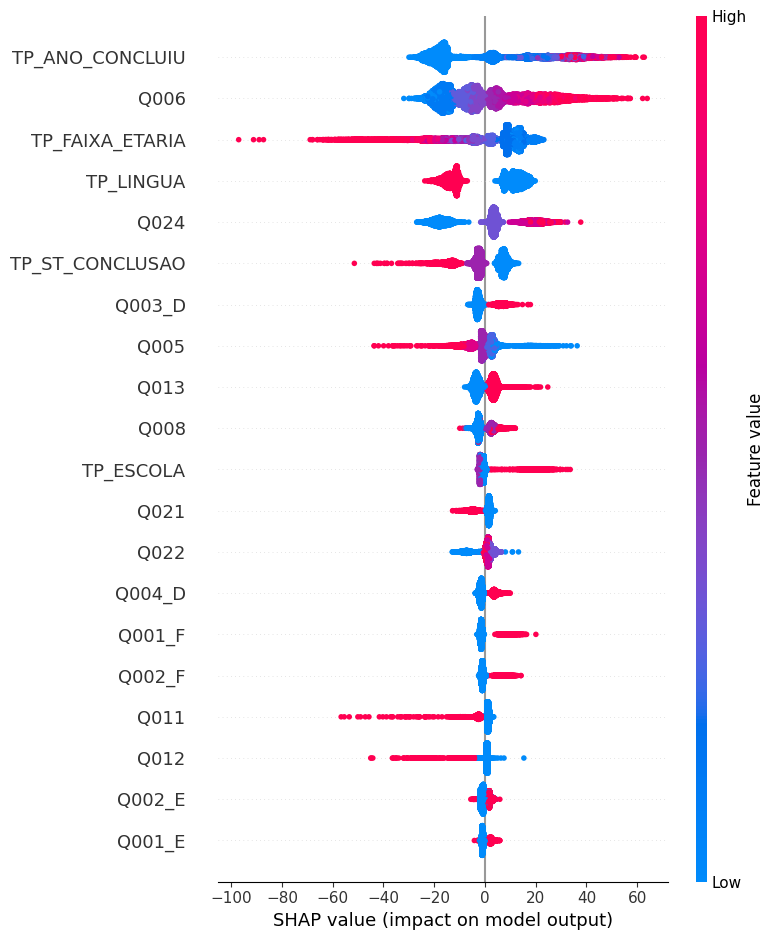

In [41]:
# Criando o objeto Explainer com base no modelo treinado
explainer = shap.Explainer(xgboost_boruta, X_train_boruta)

# Calculando os valores SHAP para o conjunto de teste
shap_values = explainer(X_test_boruta)

# Plotando o gráfico de importância das features
shap.summary_plot(shap_values, X_test_boruta)

Análise das variáveis
- `TP_ANO_CONCLUIU`: Valores mais altos dessa variável impactam de maneira positiva na predição, ou seja, possui um valor shap alto e positivo.
- `Q006` (Renda Mensal da Família): É necessário um cuidado com essa variável, pois foi realizado o Target Enconding nela, ou seja, ela possui informações diretas da média de desempenho para cada categoria da variável. Isso é refletido nos próprios valores shap e na interpretação do gráfico.
- `TP_FAIXA_ETARIA`: Valores mais altos impactam de maneira negativa na predição, possui valor shap alto e negativo. No caso, os valores mais altos indicam pessoas mais velhas.

**Esse exercício pode ser feito para todas as variáveis, a explicabilidade do modelo torna-se muito importante para o proceso de implantação.**

### 10.2 Force Plot
O Force Plot é uma visualização interativa do SHAP (SHapley Additive exPlanations) que mostra como cada feature contribui para a previsão de um modelo de machine learning. Ele é particularmente útil para entender como diferentes variáveis influenciam a previsão para um caso específico.

In [50]:
shap.initjs()  # Inicializa as visualizações interativas em SHAP

# Passando uma única explicação (exemplo para a primeira amostra)
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test_boruta.iloc[0,:])

Nesse exemplo as variáveis:
- `TP_ST_CONCLUSAO, Q005 e TP_ANO_CONCLUIU` aumentam o valor da nota média de desempenho.
    - Note que algumas variáveis podem mostrar o valor negativo, mas o coeficiente delas também e negativo, por isso o impacto na previsão é positiva.
- `TP_FAIXA_ETARIA, Q006, TP_NACIONALIDADE` diminuem o valor da nota média de desempenho.
    - Note que algumas variáveis podem mostrar o valor positivo, mas o coeficiente delas é negativo, por isso o impacto na previsão é negativa.

### 10.3 Bar Plot

Importância relativa das variáveis de maneira direta, por meio dos valores SHAP.

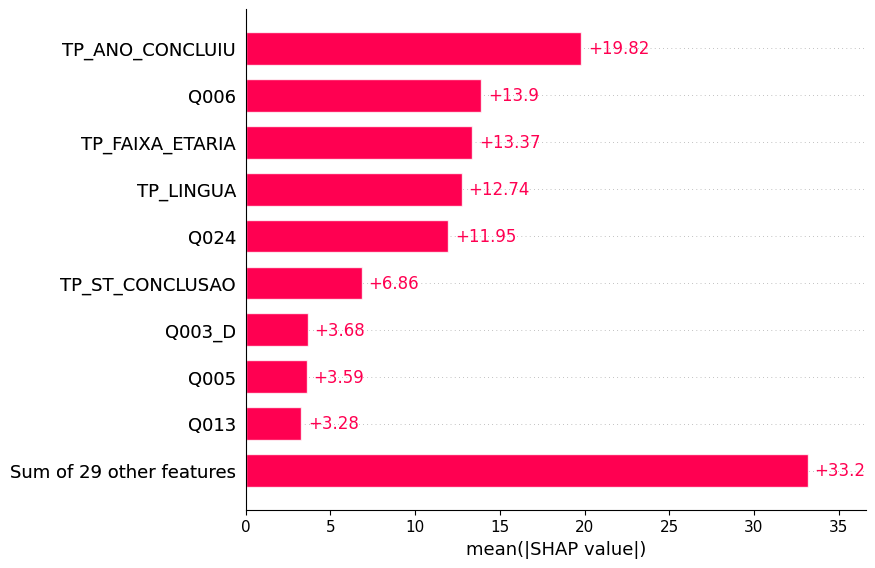

In [51]:
shap.plots.bar(shap_values)